In [46]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [47]:
#Insight1 Do teams shoot earlier 
merged_2014=pd.read_csv("merged_shots_14.csv")
merged_2013=pd.read_csv("merged_shots_13.csv")
frames = [merged_2014,merged_2013]
combined = pd.concat(frames)
combined["SCOREDIFF_BEFORE_SHOT"] = combined["SCOREMARGIN"]-combined["PTS"]

In [48]:
combined["unique"] = range(0,len(combined))
combined["fartherthan22"] = combined["SHOT_DIST"]>22
combined["closerthan10"] = combined["SHOT_DIST"]<10


In [49]:
combined["off_height"]=combined["off_height"].str.replace('-','.')
combined["def_height"]=combined["def_height"].str.replace('-','.')

In [52]:
combined.isnull().sum()

Unnamed: 0                             0
EVENTMSGACTIONTYPE                     0
EVENTMSGTYPE                           0
EVENTNUM                               0
GAME_ID                                0
HOMEDESCRIPTION                   185273
NEUTRALDESCRIPTION                393242
PCTIMESTRING                           0
PERIOD_x                               0
PERSON1TYPE                            0
PERSON2TYPE                            0
PERSON3TYPE                            0
PLAYER1_ID                             0
PLAYER1_NAME                           0
PLAYER1_TEAM_ABBREVIATION              0
PLAYER1_TEAM_CITY                      0
PLAYER1_TEAM_ID                        0
PLAYER1_TEAM_NICKNAME                  0
PLAYER2_ID                             0
PLAYER2_NAME                      289061
PLAYER2_TEAM_ABBREVIATION         289061
PLAYER2_TEAM_CITY                 289061
PLAYER2_TEAM_ID                   289061
PLAYER2_TEAM_NICKNAME             289061
PLAYER3_ID      

In [51]:
todummies = [u'ACTION_TYPE',
       u'SHOT_TYPE', u'SHOT_ZONE_BASIC', u'SHOT_ZONE_AREA']
for i in todummies:
    dummies=pd.get_dummies(combined[i])
    frames = [combined,dummies]
    combined = pd.concat(frames,axis=1)
combined = combined[pd.notnull(combined['off_height'])]

In [56]:
relevant = [u'CLOSE_DEF_DIST',u'PTS_TYPE',u'SHOT_DIST', u'TOUCH_TIME',u'Alley Oop Dunk Shot', u'Alley Oop Layup shot', u'Driving Bank Hook Shot', u'Driving Bank shot', u'Driving Dunk Shot', u'Driving Finger Roll Layup Shot', u'Driving Hook Shot', u'Driving Jump shot', u'Driving Layup Shot', u'Driving Reverse Layup Shot', u'Driving Slam Dunk Shot', u'Dunk Shot', u'Fadeaway Bank shot', u'Fadeaway Jump Shot', u'Finger Roll Layup Shot', u'Floating Jump shot', u'Hook Bank Shot', u'Hook Shot', u'Jump Bank Hook Shot', u'Jump Bank Shot', u'Jump Hook Shot',
       u'Jump Shot', u'Layup Shot', u'Pullup Bank shot', u'Pullup Jump shot', u'Putback Dunk Shot', u'Putback Layup Shot', u'Putback Reverse Dunk Shot', u'Putback Slam Dunk Shot', u'Reverse Dunk Shot', u'Reverse Layup Shot', u'Reverse Slam Dunk Shot', u'Running Bank Hook Shot', u'Running Bank shot', u'Running Dunk Shot', u'Running Finger Roll Layup Shot', u'Running Hook Shot', u'Running Jump Shot', u'Running Layup Shot', u'Running Reverse Layup Shot', u'Running Slam Dunk Shot',
       u'Running Tip Shot', u'Slam Dunk Shot', u'Step Back Jump shot', u'Tip Shot', u'Turnaround Bank Hook Shot', u'Turnaround Bank shot', u'Turnaround Fadeaway shot', u'Turnaround Hook Shot', u'Turnaround Jump Shot', u'2PT Field Goal', u'3PT Field Goal', u'Above the Break 3', u'Backcourt', u'In The Paint (Non-RA)', u'Left Corner 3', u'Mid-Range', u'Restricted Area', u'Right Corner 3', u'Back Court(BC)', u'Center(C)', u'Left Side Center(LC)', u'Left Side(L)', u'Right Side Center(RC)',
       u'Right Side(R)',"fartherthan22","closerthan10"]
target = ["SHOT_MADE_FLAG"]
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(combined.shape[0]), train_size=0.7)
mask=np.ones(combined.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)


In [54]:
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.grid_search import GridSearchCV

def cv_optimize(clf, parameters, X, Y, n_folds=5,score_func=None):
    gs = sklearn.grid_search.GridSearchCV(clf, param_grid=parameters, cv=n_folds,scoring=score_func)
    gs.fit(X, Y)
    print "BEST PARAMS", gs.best_params_
    best = gs.best_estimator_
    return best


def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
#     print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [57]:
%%time
clf, Xtrain, ytrain, Xtest, ytest = do_classify(Ridge(), {"alpha": [3]}, combined,relevant, u'SHOT_MADE_FLAG',1,score_func="mean_squared_error", mask=mask)

using mask
BEST PARAMS {'alpha': 3}
############# based on standard predict ################
Accuracy on training data: 0.12
Accuracy on test data:     0.12
########################################################
CPU times: user 16.4 s, sys: 2.01 s, total: 18.5 s
Wall time: 18.4 s


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [58]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

In [59]:
clflogitridge, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(penalty="l2"), {"C": [3]}, combined,relevant, u'SHOT_MADE_FLAG',1,score_func="mean_squared_error", reuse_split=reuse_split)


using reuse split
BEST PARAMS {'C': 3}
############# based on standard predict ################
Accuracy on training data: 0.65
Accuracy on test data:     0.65
########################################################


In [340]:
probs = clflogitridge.predict_proba(combined[relevant])
p0 = probs[:,0]
p1 = probs[:,1]
print probs
# print mean_squared_error(p1, ytest)
# print confusion_matrix(ytest, clflogitridge.predict(combined[relevant]))


[[ 0.635199    0.364801  ]
 [ 0.2670667   0.7329333 ]
 [ 0.50456649  0.49543351]
 ..., 
 [ 0.30349843  0.69650157]
 [ 0.69008078  0.30991922]
 [ 0.74028377  0.25971623]]


In [341]:
combined["SHOT_PROB"]=p1

In [342]:

combined.plot("SCOREDIFF_BEFORE_SHOT","SHOT_CLOCK",kind="scatter")

In [134]:
combined.head()

Unnamed: 0  EVENTMSGACTIONTYPE  EVENTMSGTYPE  EVENTNUM   GAME_ID           HOMEDESCRIPTION  NEUTRALDESCRIPTION PCTIMESTRING  PERIOD_x  PERSON1TYPE  PERSON2TYPE  PERSON3TYPE  PLAYER1_ID    PLAYER1_NAME PLAYER1_TEAM_ABBREVIATION PLAYER1_TEAM_CITY  PLAYER1_TEAM_ID PLAYER1_TEAM_NICKNAME  PLAYER2_ID   PLAYER2_NAME PLAYER2_TEAM_ABBREVIATION PLAYER2_TEAM_CITY  PLAYER2_TEAM_ID PLAYER2_TEAM_NICKNAME  PLAYER3_ID  PLAYER3_NAME PLAYER3_TEAM_ABBREVIATION PLAYER3_TEAM_CITY  PLAYER3_TEAM_ID  \
0           0                   1             2         2  21400001  MISS Davis 20' Jump Shot                 NaN        11:43         1            4            0            0      203076   Anthony Davis                       NOP       New Orleans       1610612740              Pelicans           0            NaN                       NaN               NaN              NaN                   NaN           0           NaN                       NaN               NaN              NaN   
1           1                  66             1         4  21400001                       NaN                 NaN        11:31         1            5            5            0      202696  Nikola Vucevic                       ORL           Orlando       1610612753                 Magic      203901  Elfrid Payton                       ORL           Orlando       1610612753                 Magic           0           NaN                       NaN               NaN              NaN   
2           2                   1             2         7  21400001  MISS Davis 18' Jump Shot                 NaN        11:06         1            4            0            0      203076   Anthony Davis                       NOP       New Orleans       1610612740              Pelicans           0            NaN                       NaN               NaN              NaN                   NaN           0           NaN                       NaN               NaN              NaN   
3           3                   5             2         9  21400001     Holiday BLOCK (1 BLK)                 NaN        10:54         1            5            0            4      203901   Elfrid Payton                       ORL           Orlando       1610612753                 Magic           0            NaN                       NaN               NaN              NaN                   NaN      201950  Jrue Holiday                       NOP       New Orleans       1610612740   
4           4                   7             1        25  21400001       Davis  Dunk (2 PTS)                 NaN        10:29         1            4            0            0      203076   Anthony Davis                       NOP       New Orleans       1610612740              Pelicans           0            NaN                       NaN               NaN              NaN                   NaN           0           NaN                       NaN               NaN              NaN   

  PLAYER3_TEAM_NICKNAME  SCORE  SCOREMARGIN                                 VISITORDESCRIPTION WCTIMESTRING  HOME_TEAM_ID  AWAY_TEAM_ID  HOME_PLAYER1_ID  HOME_PLAYER2_ID  HOME_PLAYER3_ID  HOME_PLAYER4_ID  HOME_PLAYER5_ID  AWAY_PLAYER1_ID  AWAY_PLAYER2_ID  AWAY_PLAYER3_ID  AWAY_PLAYER4_ID  AWAY_PLAYER5_ID  ACTION_BEFORE  Unnamed: 0.1 CLOSEST_DEFENDER  CLOSEST_DEFENDER_PLAYER_ID    ...      Hook Bank Shot  Hook Shot  Jump Bank Hook Shot  Jump Bank Shot Jump Hook Shot  Jump Shot Layup Shot  \
0                   NaN    NaN            0                                                NaN      8:14 PM    1610612740    1610612753           201569           201600           201950           201936           203076           202696           203124           202699           203901           203095             10         19654    O'Quinn, Kyle                      203124    ...                   0          0                    0               0              0          1          0   
1                   NaN  2 - 0            2  Vucevic 19' Jump Bank Shot (2 PTS) (Payton 1 

[ 0.          0.         -0.00029899 ..., -0.00059797 -0.00044848
 -0.00059797]


                            OLS Regression Results                            
Dep. Variable:             SHOT_CLOCK   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1082.
Date:                Tue, 01 Dec 2015   Prob (F-statistic):               0.00
Time:                        17:29:11   Log-Likelihood:            -1.1825e+06
No. Observations:              372928   AIC:                         2.365e+06
Df Residuals:                  372925   BIC:                         2.365e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                13.16

In [405]:
combined["POE"]=combined["SHOT_MADE_FLAG"]-combined["SHOT_PROB"]
relevantcolumns = ["SCOREDIFF_BEFORE_SHOT","SHOT_CLOCK","SHOT_PROB","PERIOD_x","SHOT_MADE_FLAG","POE"]
selected = combined[relevantcolumns]
# selected["SCOREDIFF_BEFORE_SHOT"]=normalize(selected.SCOREDIFF_BEFORE_SHOT.values)[0]
grouped_period = selected.groupby(["PERIOD_x"]).agg("mean")
print grouped_period.index.values
print grouped_period.SHOT_PROB.values
plt.figure()
plt.plot(grouped_period.index,grouped_period.SHOT_PROB,label="SHOT PROBABILITY")
plt.plot(grouped_period.index,grouped_period.SHOT_MADE_FLAG,label="SHOT MADE")
plt.xlabel("PERIOD")
plt.legend()
plt.figure()
plt.plot(grouped_period.index,grouped_period.POE,label="POE")
plt.xlabel("PERIOD")
plt.legend()
plt.figure()
plt.plot(grouped_period.index,grouped_period.SHOT_CLOCK,label="SHOT CLOCK")
plt.xlabel("PERIOD")
plt.legend()
plt.figure()
plt.plot(grouped_period.index,grouped_period.SCOREDIFF_BEFORE_SHOT,label="SCORE DIFF")
plt.xlabel("PERIOD")
plt.legend()

print grouped_period


[1 2 3 4 5 6 7]
[ 0.45910342  0.45674568  0.44970738  0.44535988  0.4254931   0.41052512
  0.41787242]
          SCOREDIFF_BEFORE_SHOT  SHOT_CLOCK  SHOT_PROB  SHOT_MADE_FLAG       POE
PERIOD_x                                                                        
1                     -0.546509   12.869220   0.459103        0.462504  0.003401
2                     -0.595285   12.639735   0.456746        0.453979 -0.002766
3                     -0.587928   12.449364   0.449707        0.454323  0.004615
4                     -0.778847   12.037365   0.445360        0.441066 -0.004294
5                     -0.863929   11.402329   0.425493        0.396940 -0.028553
6                     -1.171429   10.663472   0.410525        0.417582  0.007057
7                     -0.744898   10.770667   0.417872        0.438776  0.020903


In [471]:


grouped = selected.groupby(["SCOREDIFF_BEFORE_SHOT","PERIOD_x"],as_index=False)
# grouped = selected.groupby(["SCOREDIFF_BEFORE_SHOT","PERIOD_x"],as_index=False)
aggregated = grouped.agg(['mean', 'median','count',"std"])
aggregated = grouped.agg(['mean', 'median','count',"std"])
aggregated_bigsamples = aggregated[aggregated["SHOT_CLOCK"]["count"]>=5]
aggregated_bigsamples["INDEX"] = aggregated_bigsamples.index
unzipped = zip(*aggregated_bigsamples["INDEX"].values)
difference = list(unzipped[0])
period = list(unzipped[1])
aggregated_bigsamples["SCOREDIFF"]=difference
aggregated_bigsamples["PERIOD"]=period


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-v

In [483]:
df = pd.DataFrame({"scorediff":aggregated_bigsamples["SCOREDIFF"].values,
                   "shotclock":aggregated_bigsamples["SHOT_CLOCK"]["mean"].values,
                   "period":aggregated_bigsamples["PERIOD"].values,
                    "poe":aggregated_bigsamples["POE"]["mean"].values,
                   "shotmade":aggregated_bigsamples["SHOT_MADE_FLAG"]["mean"].values,
                   "shotcount":aggregated_bigsamples["SHOT_MADE_FLAG"]["count"].values,
                    "shotprob":aggregated_bigsamples["SHOT_PROB"]["mean"].values})
df= df[(df.scorediff>=-30) & (df.scorediff<=30)]
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import normalize


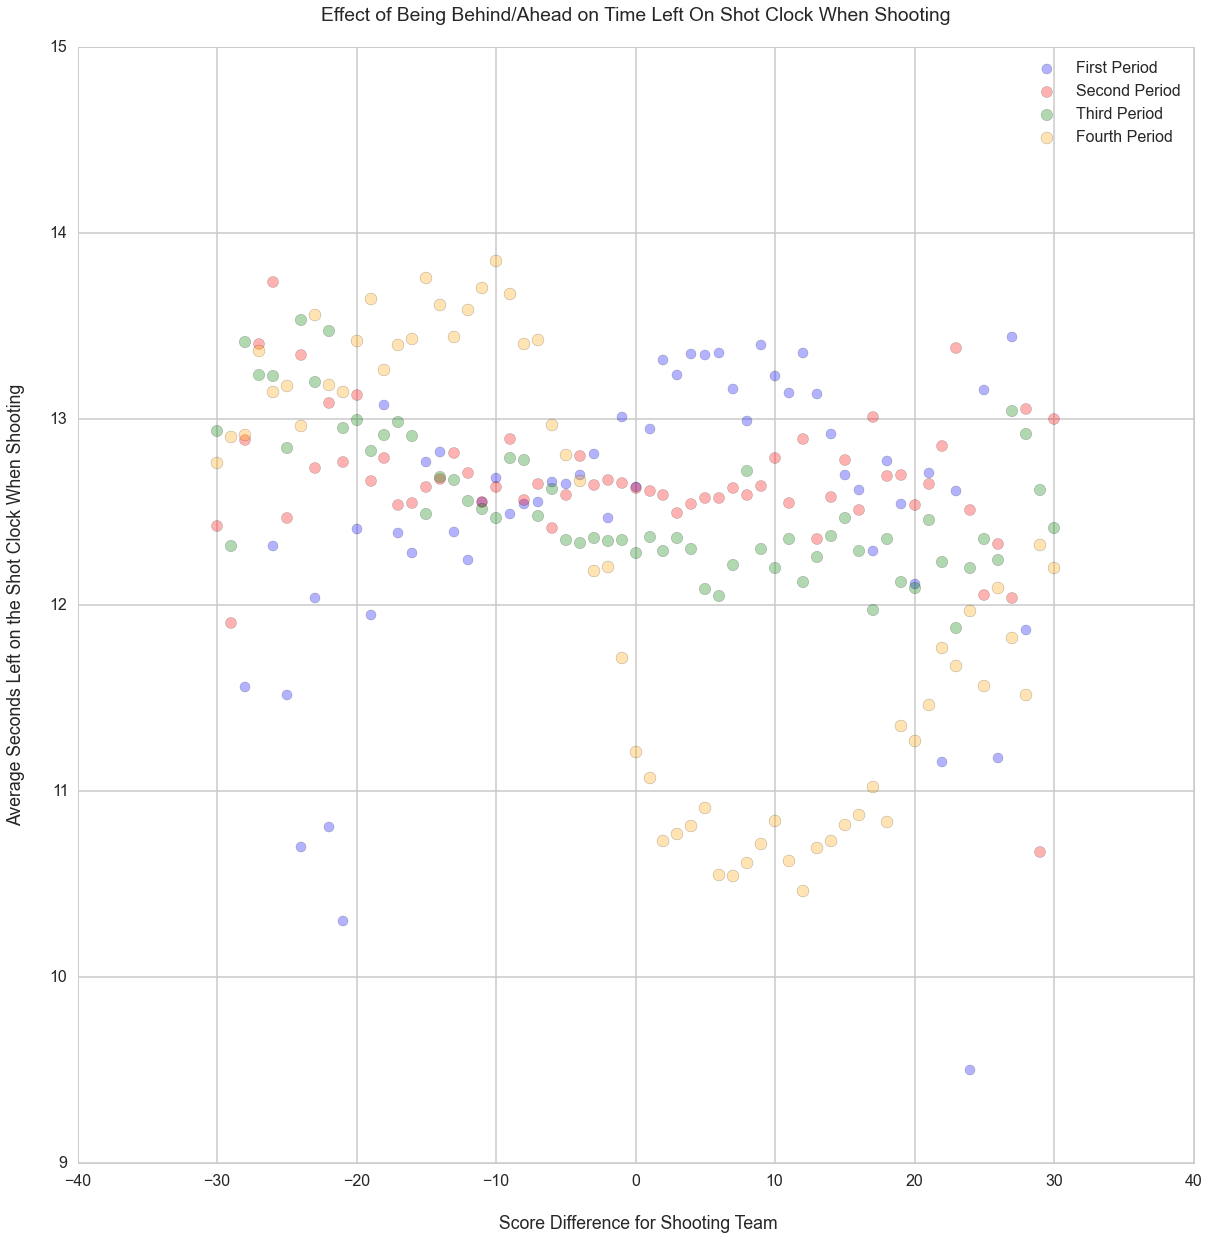

In [489]:
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(first.scorediff,first.shotclock,c="b",s=100,label="First Period",alpha=.3)
plt.scatter(second.scorediff,second.shotclock,c="r",s=120,label="Second Period",alpha=.3)
plt.scatter(third.scorediff,third.shotclock,c="g",s=130,label="Third Period",alpha=.3)
plt.scatter(fourth.scorediff,fourth.shotclock,c="orange",s=140,label="Fourth Period",alpha=.3)
plt.ylabel('Average Seconds Left on the Shot Clock When Shooting \n')
plt.xlabel('\n Score Difference for Shooting Team')
plt.title('Effect of Being Behind/Ahead on Time Left On Shot Clock When Shooting \n')
plt.legend()


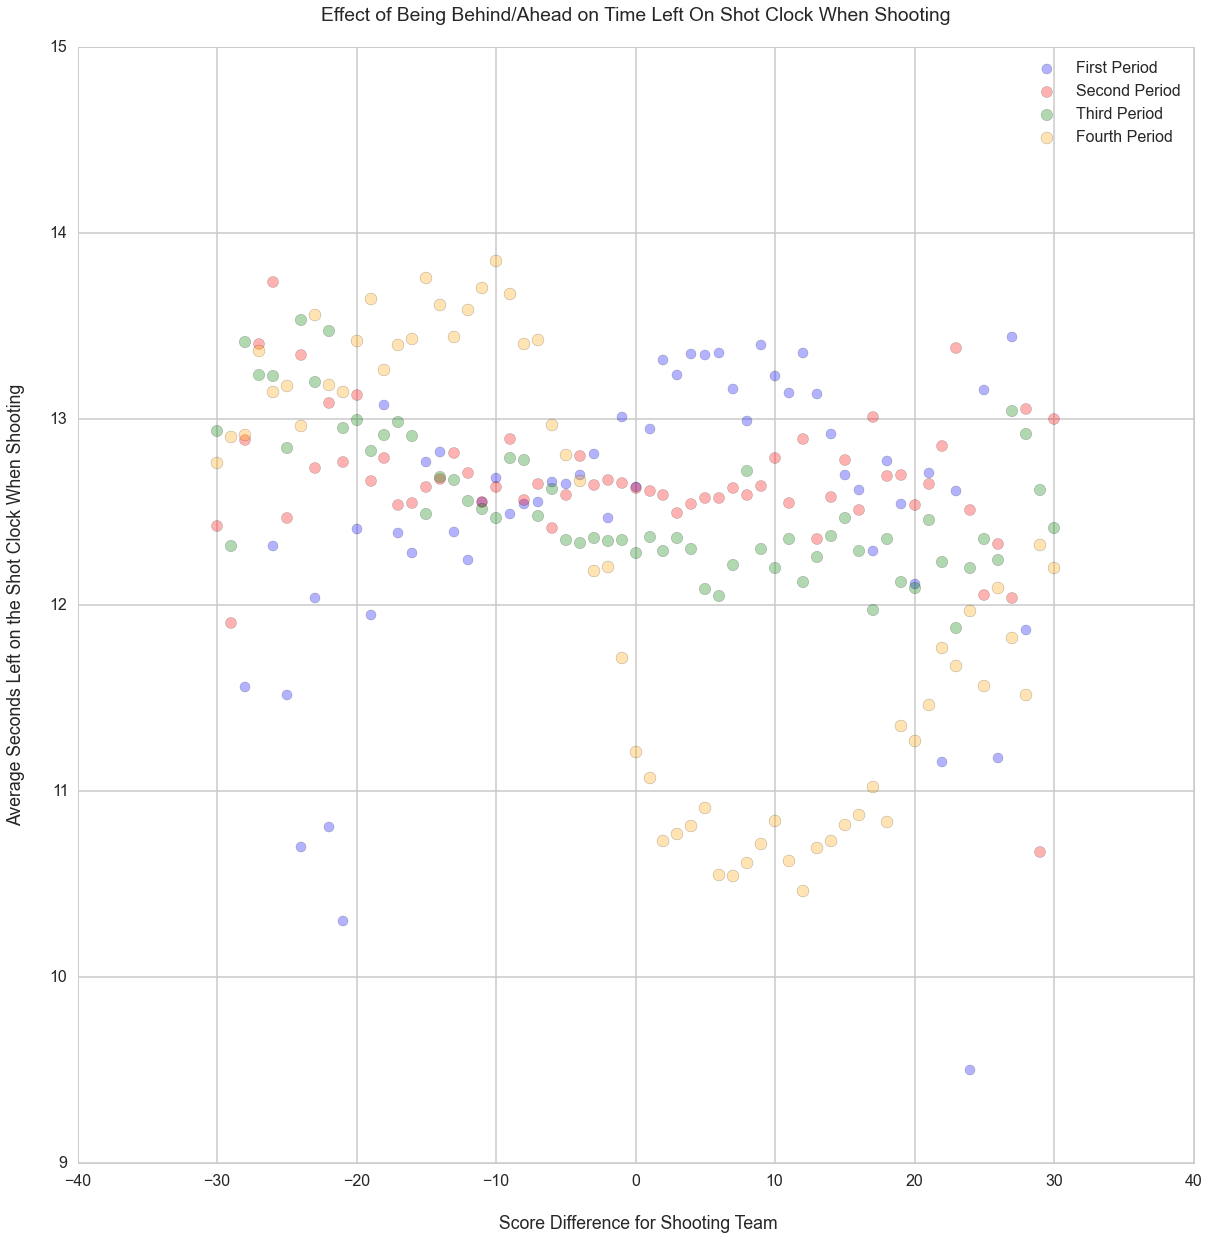

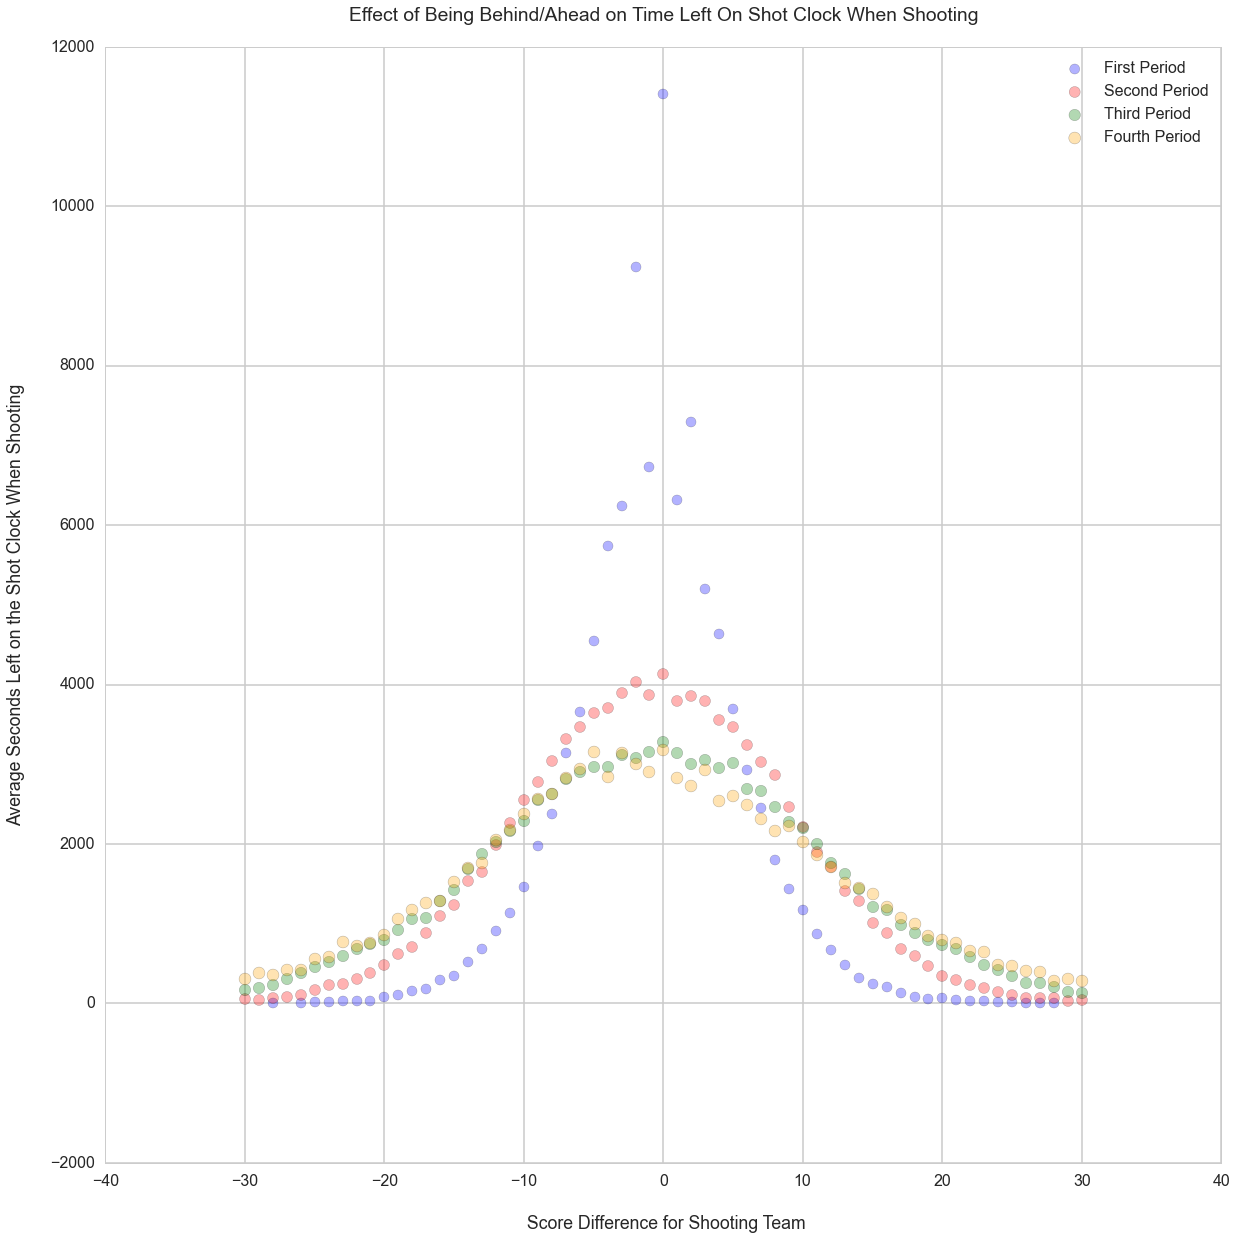

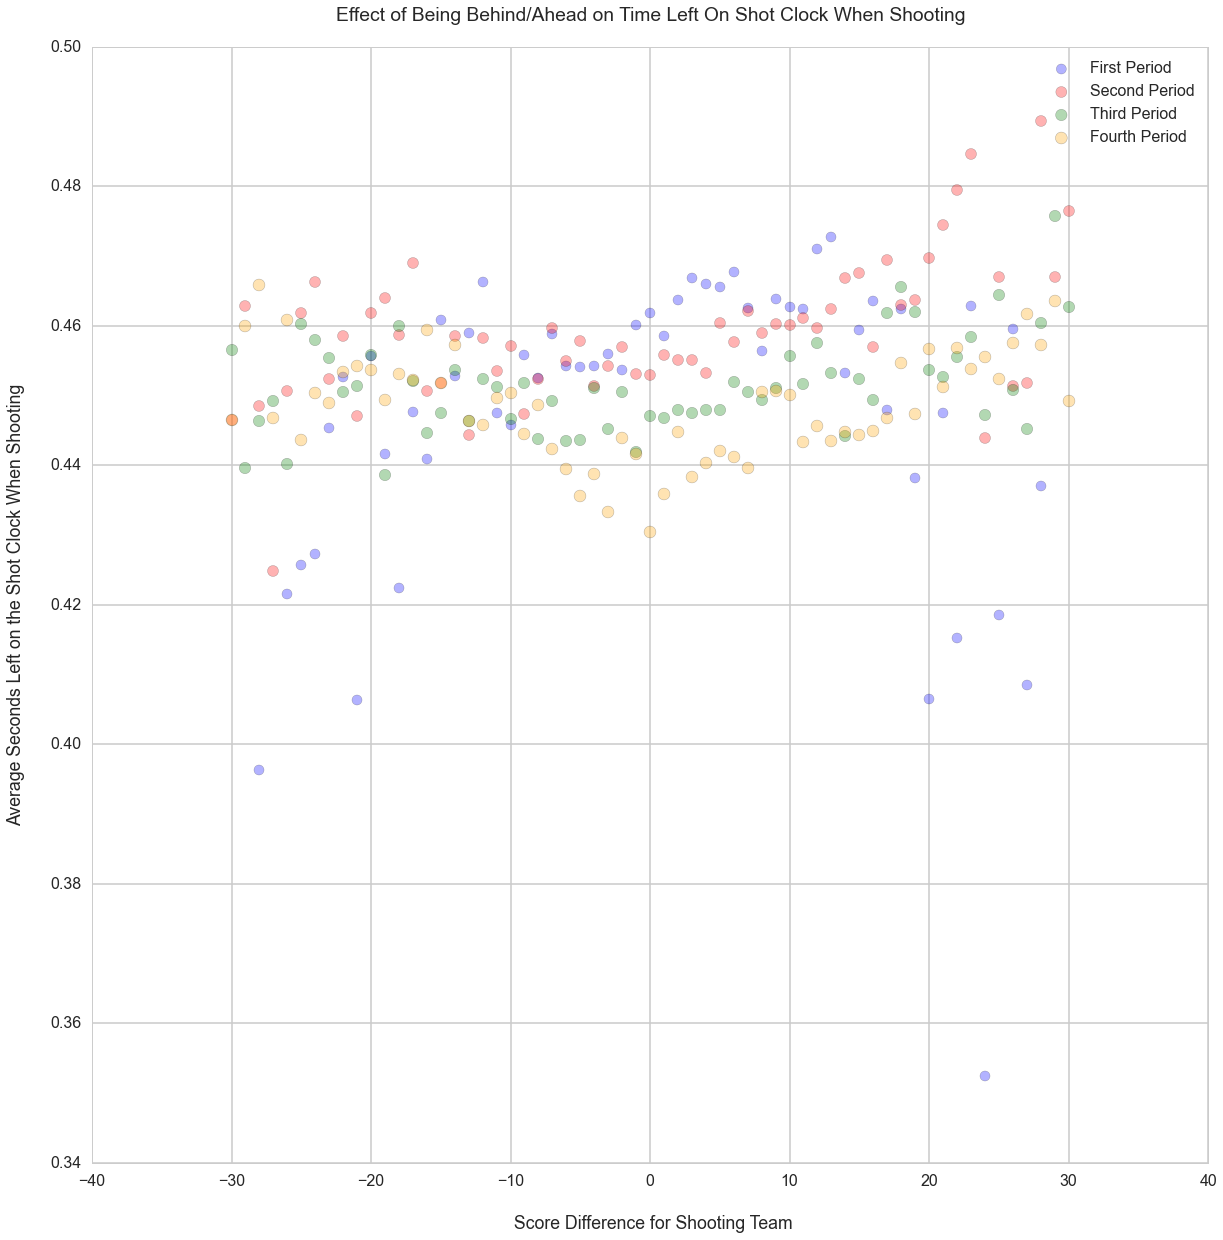

In [488]:
%matplotlib inline

first = df[df.period==1]
second = df[df.period==2]
third = df[df.period==3]
fourth = df[df.period==4]


first = df[df.period==1]
second = df[df.period==2]
third = df[df.period==3]
fourth = df[df.period==4]
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(first.scorediff,first.shotcount,c="b",s=100,label="First Period",alpha=.3)
plt.scatter(second.scorediff,second.shotcount,c="r",s=120,label="Second Period",alpha=.3)
plt.scatter(third.scorediff,third.shotcount,c="g",s=130,label="Third Period",alpha=.3)
plt.scatter(fourth.scorediff,fourth.shotcount,c="orange",s=140,label="Fourth Period",alpha=.3)
plt.ylabel('Average Seconds Left on the Shot Clock When Shooting \n')
plt.xlabel('\n Score Difference for Shooting Team')
plt.title('Effect of Being Behind/Ahead on Time Left On Shot Clock When Shooting \n')
plt.legend()


first = df[df.period==1]
second = df[df.period==2]
third = df[df.period==3]
fourth = df[df.period==4]







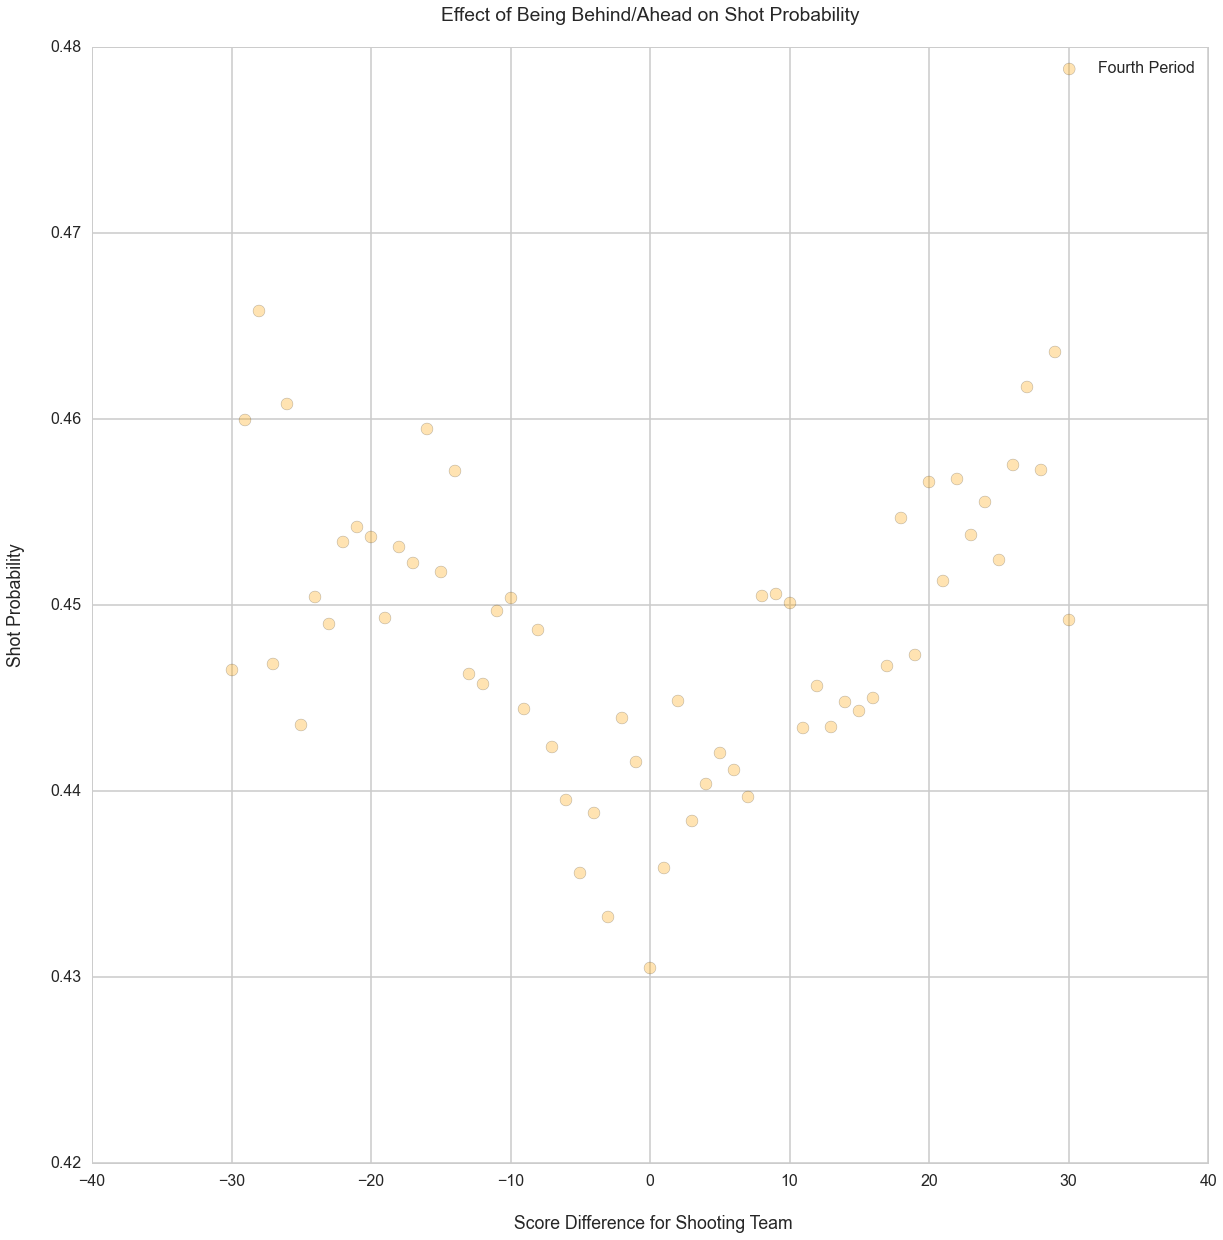

In [500]:
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
# plt.scatter(first.scorediff,first.shotprob,c="b",s=100,label="First Period",alpha=.3)
# plt.scatter(second.scorediff,second.shotprob,c="r",s=120,label="Second Period",alpha=.3)
# plt.scatter(third.scorediff,third.shotprob,c="g",s=130,label="Third Period",alpha=.3)
plt.scatter(fourth.scorediff,fourth.shotprob,c="orange",s=140,label="Fourth Period",alpha=.3)
plt.ylabel('Shot Probability \n')
plt.xlabel('\n Score Difference for Shooting Team')
plt.title('Effect of Being Behind/Ahead on Shot Probability \n')
plt.legend()

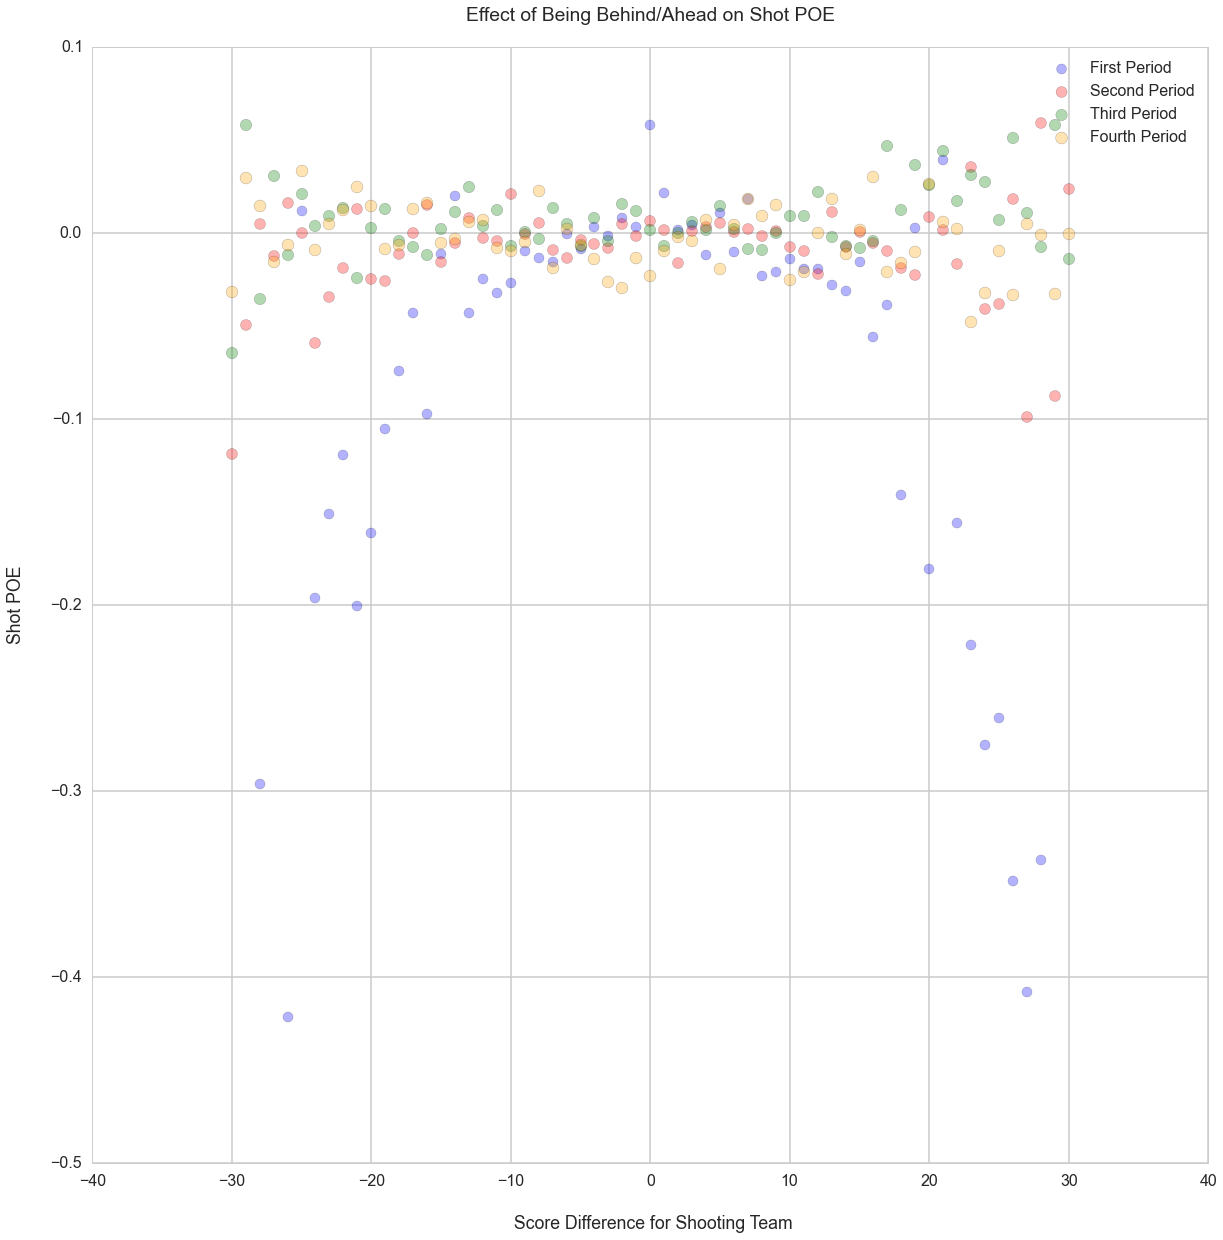

In [495]:
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(first.scorediff,first.poe,c="b",s=100,label="First Period",alpha=.3)
plt.scatter(second.scorediff,second.poe,c="r",s=120,label="Second Period",alpha=.3)
plt.scatter(third.scorediff,third.poe,c="g",s=130,label="Third Period",alpha=.3)
plt.scatter(fourth.scorediff,fourth.poe,c="orange",s=140,label="Fourth Period",alpha=.3)
plt.ylabel('Shot POE \n')
plt.xlabel('\n Score Difference for Shooting Team')
plt.title('Effect of Being Behind/Ahead on Shot POE \n')
plt.legend()

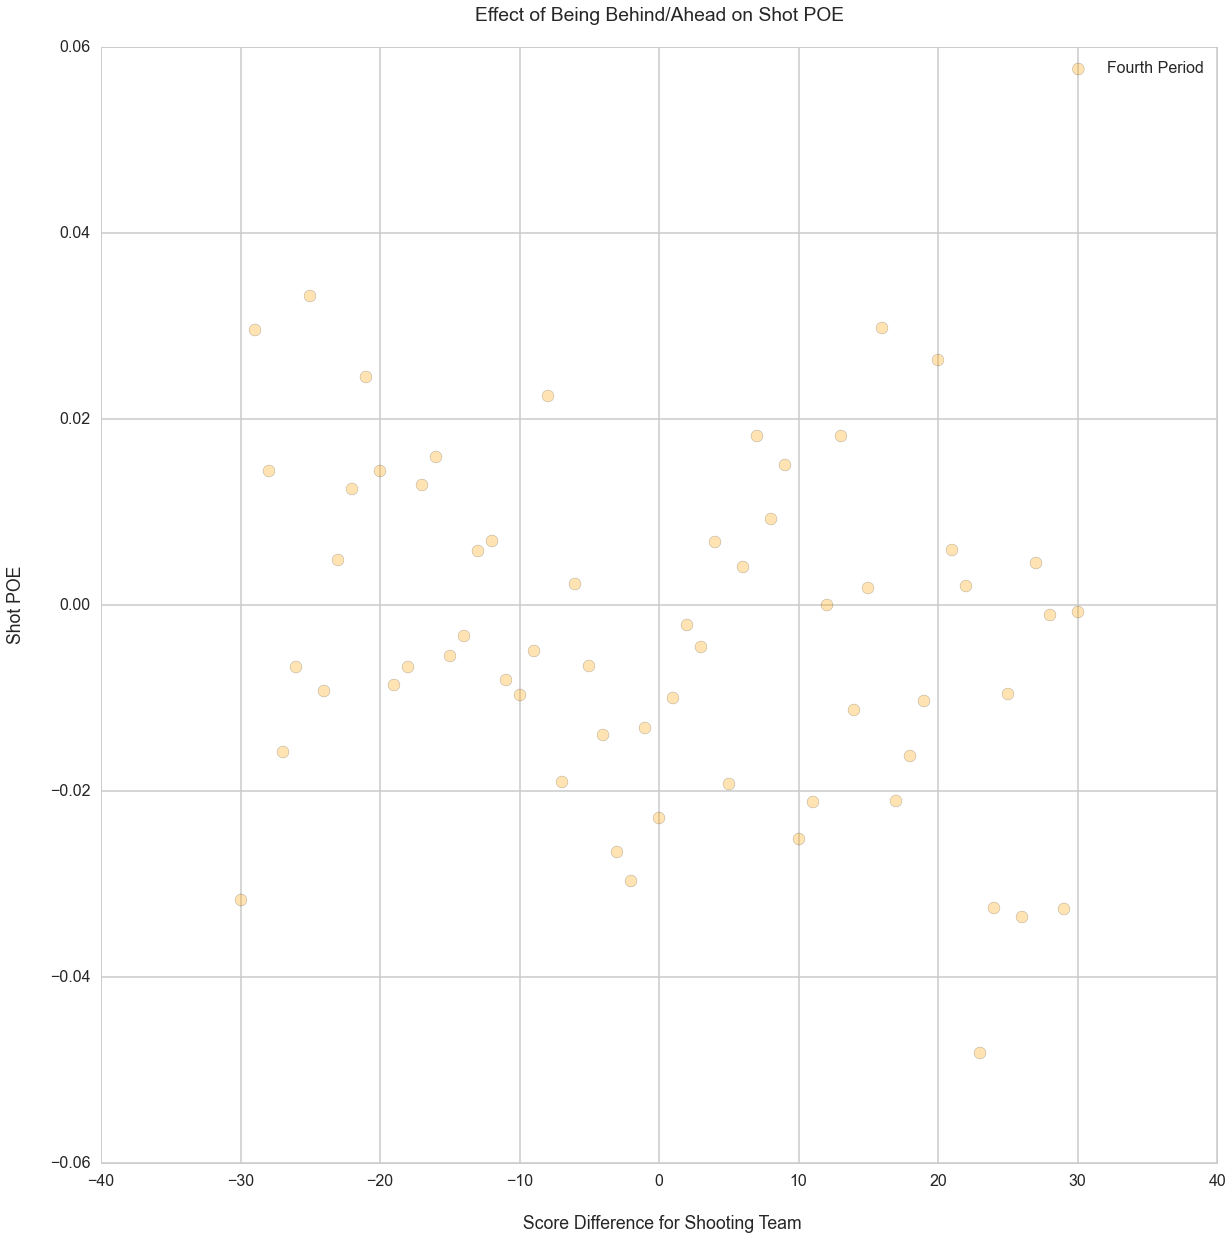

In [496]:
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(fourth.scorediff,fourth.poe,c="orange",s=140,label="Fourth Period",alpha=.3)
plt.ylabel('Shot POE \n')
plt.xlabel('\n Score Difference for Shooting Team')
plt.title('Effect of Being Behind/Ahead in the Fourth Quarter on Shot POE \n')
plt.legend()

In [1]:
plt.figure()
plt.scatter(fourth.scorediff,fourth.shotclock-np.mean(fourth.shotclock),c="orange",s=140,label="Shotclock in 4th")
plt.legend()
#mean-centered shotclock 

NameError: name 'plt' is not defined

In [ ]:
plt.figure()
plt.scatter(fourth.scorediff,fourth.shotprob-np.mean(fourth.shotprob),c="orange",s=140,label="Probability in 4th")
plt.legend()
#mean centered shot probability 

In [ ]:
plt.figure()
plt.scatter(fourth.scorediff,fourth.poe,c="orange",s=140,label="Poe in 4th")
plt.legend()
#fourth quarter points relative to expectation

In [ ]:

plt.figure()
plt.scatter(fourth.scorediff,fourth.shotmade-np.mean(fourth.shotmade),c="orange",s=140,label="Made in 4th")
plt.legend()


In [ ]:
#now with respect to shotclock rather than score

plt.figure()
plt.scatter(fourth.shotclock,fourth.shotprob-np.mean(fourth.shotprob),c="orange",s=140,label="Prob in 4th")
plt.legend()

plt.figure()
plt.scatter(fourth.shotclock,fourth.poe,c="orange",s=140,label="Poe in 4th")
plt.legend()

plt.figure()
plt.scatter(fourth.shotclock,fourth.shotmade-np.mean(fourth.shotmade),c="orange",s=140,label="Average Made in 4th")
plt.legend()
plt.show()


plt.figure()
plt.scatter(fourth.shotclock,fourth.scorediff,c="orange",s=140,label="Difference in 4th")
plt.legend()
plt.show()




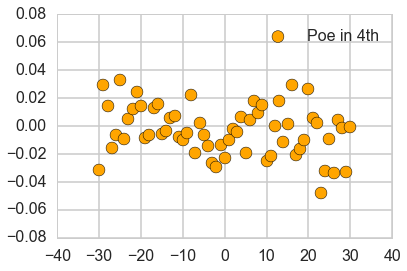

In [429]:
plt.figure()
plt.scatter(fourth.scorediff,fourth.poe,c="orange",s=140,label="Poe in 4th")
plt.legend()

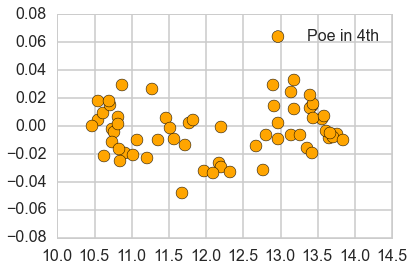

In [428]:
plt.figure()
plt.scatter(fourth.shotclock,fourth.poe,c="orange",s=140,label="Poe in 4th")
plt.legend()


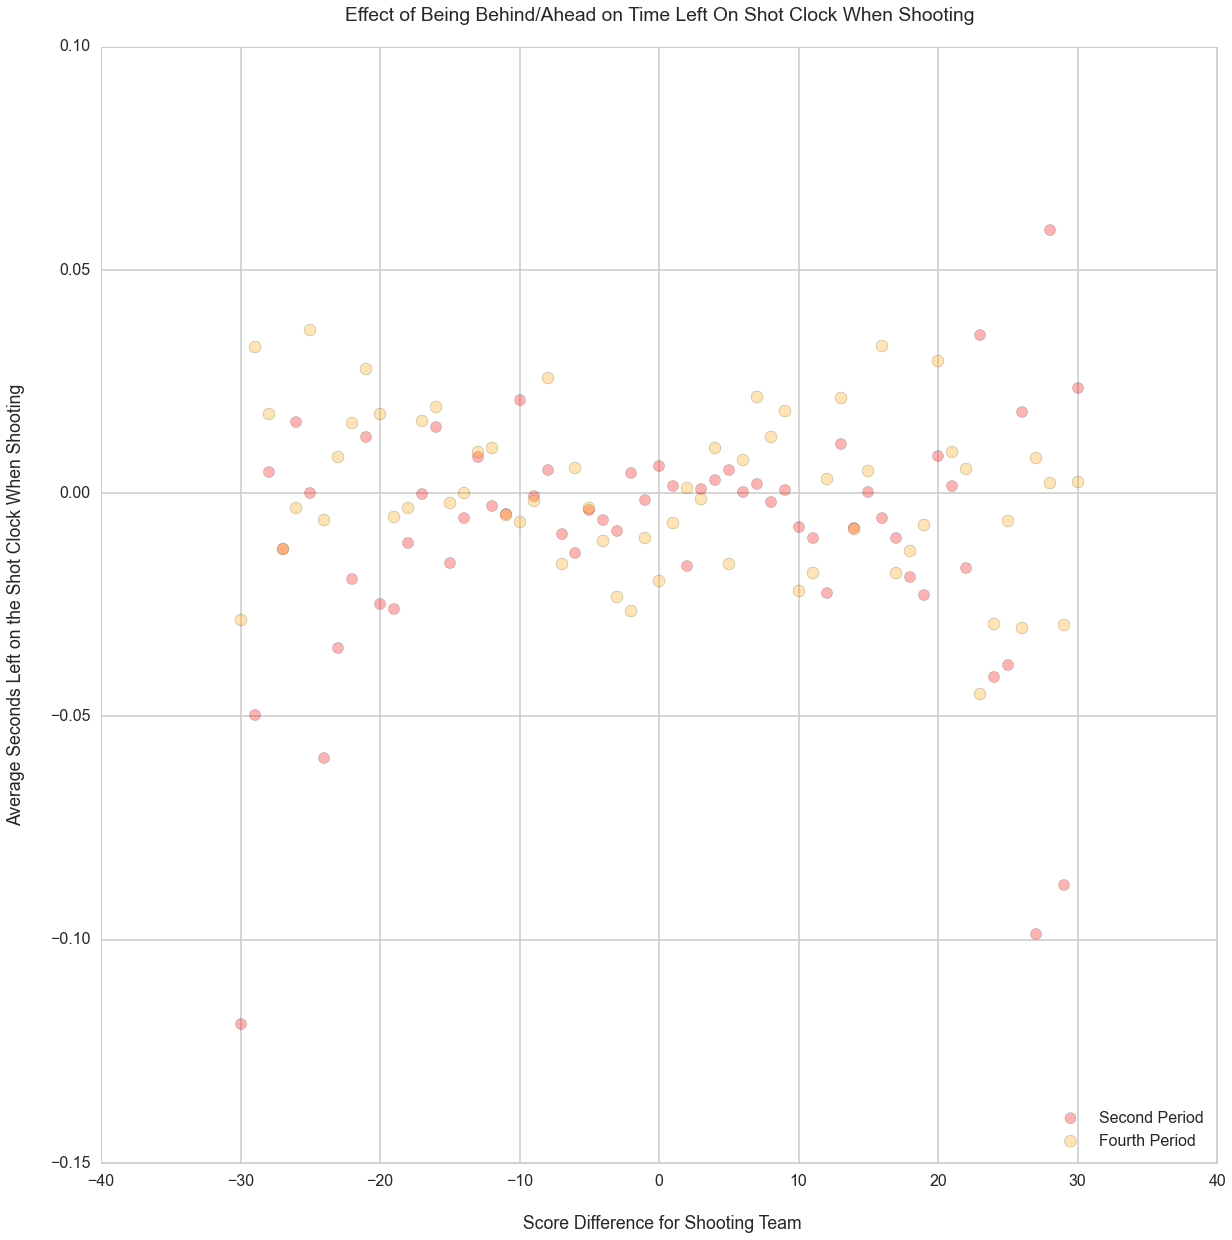

In [460]:
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')

# plt.scatter(first.scorediff,first.poe,c="b",s=100,label="First Period",alpha=.3)
plt.scatter(second.scorediff,second.poe,c="r",s=120,label="Second Period",alpha=.3)
# plt.scatter(third.scorediff,third.poe,c="g",s=130,label="Third Period",alpha=.3)
plt.scatter(fourth.scorediff,fourth.poe-np.mean(fourth.poe),c="orange",s=140,label="Fourth Period",alpha=.3)
# plt.ylabel('Average Seconds Left on the Shot Clock When Shooting \n')
# plt.xlabel('\n Score Difference for Shooting Team')
# plt.title('Effect of Being Behind/Ahead on Time Left On Shot Clock When Shooting \n')
plt.legend(loc=4)


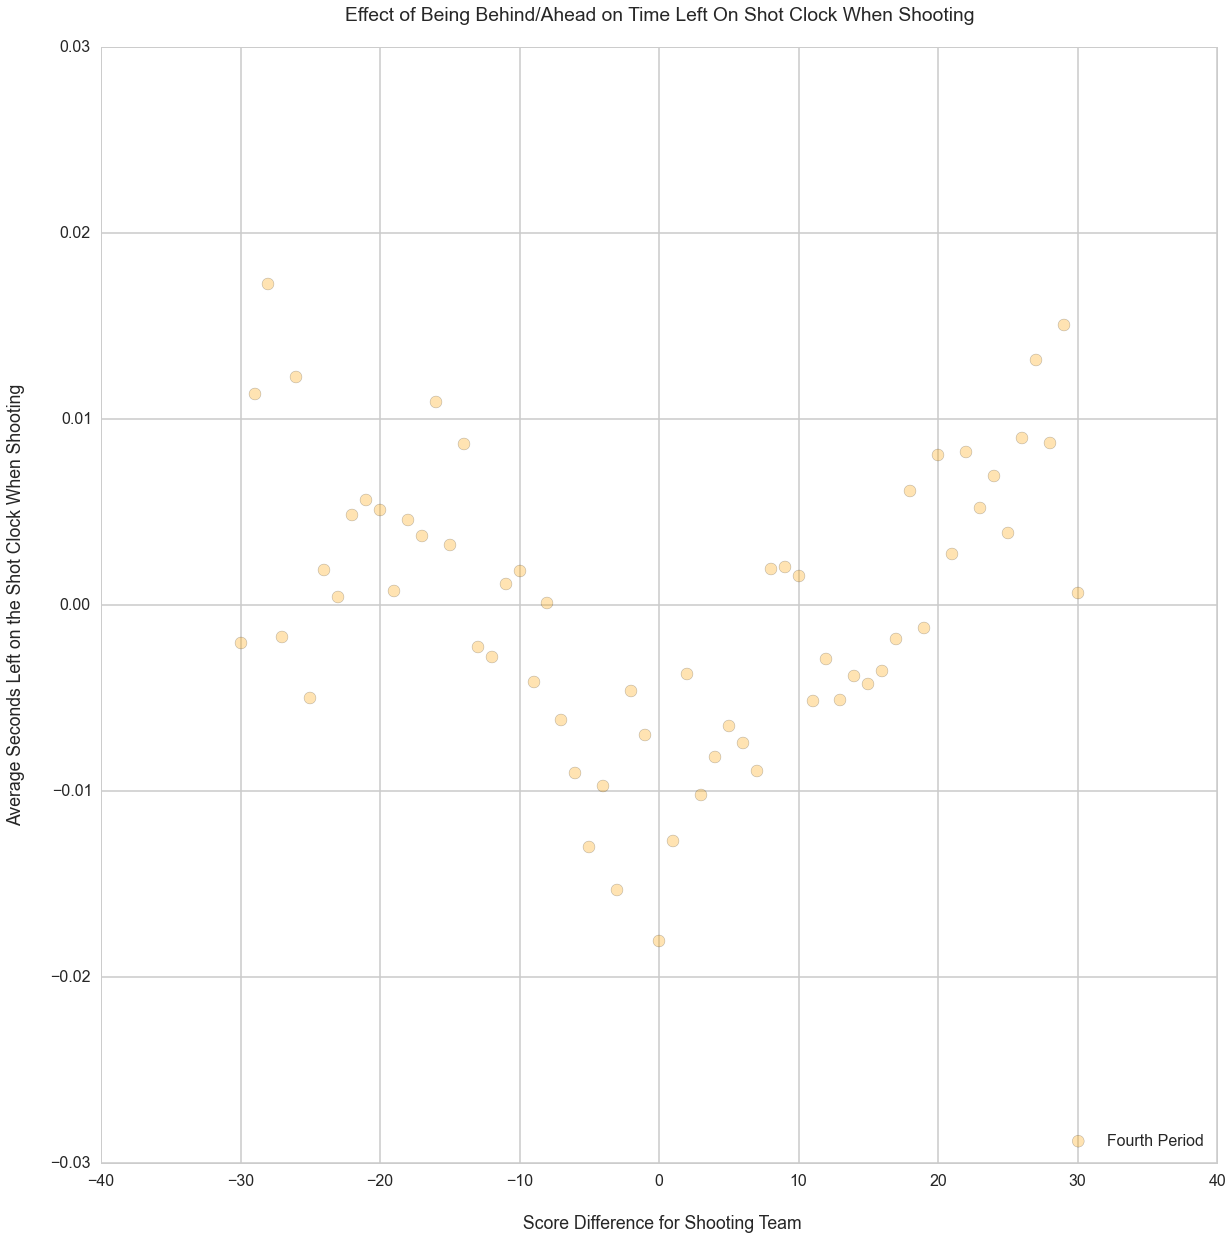

In [487]:
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')

# plt.scatter(first.scorediff,first.shotprob-np.mean(first.shotprob),c="b",s=100,label="First Period",alpha=.3)
# plt.scatter(second.scorediff,second.shotprob-np.mean(second.shotprob),c="r",s=120,label="Second Period",alpha=.3)
# plt.scatter(third.scorediff,third.shotprob-np.mean(third.shotprob),c="g",s=130,label="Third Period",alpha=.3)
plt.scatter(fourth.scorediff,fourth.shotprob-np.mean(fourth.shotprob),c="orange",s=140,label="Fourth Period",alpha=.3)
# plt.ylabel('Average Seconds Left on the Shot Clock When Shooting \n')
# plt.xlabel('\n Score Difference for Shooting Team')
# plt.title('Effect of Being Behind/Ahead on Time Left On Shot Clock When Shooting \n')
plt.legend(loc=4)


In [281]:
# relevantcolumns = ["SCOREDIFF_BEFORE_SHOT","SHOT_CLOCK","SHOT_PROB"]
# selected = combined[relevantcolumns]
# # selected["SCOREDIFF_BEFORE_SHOT"]=normalize(selected.SCOREDIFF_BEFORE_SHOT.values)[0]
# grouped = selected.groupby(["SCOREDIFF_BEFORE_SHOT"],as_index=False)
# # grouped = selected.groupby(["SCOREDIFF_BEFORE_SHOT","PERIOD_x"],as_index=False)
# aggregated = grouped.agg(['mean', 'count',"std"])
# aggregated_bigsamples = aggregated[aggregated["SHOT_CLOCK"]["count"]>=5]
# aggregated_bigsamples["INDEX"] = aggregated_bigsamples.index

# plt.scatter(aggregated_bigsamples.index,aggregated_bigsamples["SHOT_CLOCK"]["mean"])
# plt.ylabel('Average Seconds Left on the Shot Clock When Shooting \n')
# plt.xlabel('\n Score Difference for Shooting Team')
# plt.title('Effect of Being Behind/Ahead on Time Left On Shot Clock When Shooting \n')